In [19]:
import json # will be needed for saving preprocessing details
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np # for data manipulation
import pandas as pd # for data manipulation
import seaborn as sns
from sklearn.model_selection import train_test_split # will be used for data split
from sklearn.preprocessing import LabelEncoder # for preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler # Scaling continious values as sd=1
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor # for training the algorithm
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor # for training the algorithm
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score
import joblib # for saving algorithm and preprocessing objects

In [20]:
# load dataset
df = pd.read_csv('../data/emlakfinal1.csv', index_col=0, encoding='latin1')
# show first rows of data
list(df.columns)

C:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (24,25,192) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


['ilan_no',
 'url',
 'ilan_tarihi',
 'origin',
 'il',
 'ilce',
 'mah',
 'coord_lat',
 'coord_long',
 'emlak_tipi',
 'm2_net',
 'm2_brut',
 'oda_sayisi',
 'bina_yasi',
 'bulundugu_kat',
 'kat_sayisi',
 'isitma',
 'banyo_sayisi',
 'balkon',
 'esyali',
 'kullanim_durumu',
 'site_icerisinde',
 'aidat_tl',
 'zemin_etudu',
 'tapu_durumu',
 'krediye_uygun',
 'kimden',
 'takas',
 'dogu',
 'bati',
 'kuzey',
 'guney',
 'adsl',
 'ahsap_dograma',
 'akilli_ev',
 'alarm_hirsiz',
 'alarm_yangin',
 'alaturka_tuvalet',
 'aluminyum_dograma',
 'amerikan_kapi',
 'amerikan_mutfak',
 'ankastre_firin',
 'asansor_ic',
 'balkon_ic',
 'barbeku',
 'beyaz_esya',
 'boyali',
 'bulasik_makinesi',
 'buzdolabi',
 'duvar_kagidi',
 'dusakabin',
 'ebeveyn_banyosu',
 'fiber_internet',
 'firin',
 'giyinme_odasi',
 'gomme_dolap',
 'goruntulu_diafon',
 'hilton_banyo',
 'intercom_sistemi',
 'isicam',
 'jakuzi',
 'kartonpiyer',
 'kiler',
 'klima',
 'kuvet',
 'laminat_zemin',
 'marley',
 'mobilya',
 'mutfak_ankastre',
 'mutfak_

# Visualize categorical variables

In [3]:
def visualizeAllFeatures(df):
    fig, axs = plt.subplots(5,4,figsize=(82,74), subplot_kw=dict(projection='rectilinear'), gridspec_kw={'hspace':1.8, 'wspace':0.3})
    
    # rotate all x axis labels. Scans 5x4 two dimentional array
    for ax in axs:
        for a in ax:
            a.tick_params(labelrotation=90)
    sns.countplot(df['emlak_tipi'], ax=axs[0][0])
    sns.countplot(df['oda_sayisi'], ax=axs[0][1])
    sns.countplot(df['bina_yasi'], ax=axs[0][2])
    sns.countplot(df['bulundugu_kat'], ax=axs[0][3])
    #
    sns.countplot(df['kat_sayisi'], ax=axs[1][0])
    sns.countplot(df['isitma'], ax=axs[1][1])
    sns.countplot(df['banyo_sayisi'], ax=axs[1][2])
    sns.countplot(df['balkon'], ax=axs[1][3])
    #
    sns.countplot(df['esyali'], ax=axs[2][0])
    sns.countplot(df['kullanim_durumu'], ax=axs[2][1])
    sns.countplot(df['site_icerisinde'], ax=axs[2][2])
    sns.countplot(df['aidat_tl'], ax=axs[2][3])
    #
    sns.countplot(df['zemin_etudu'], ax=axs[3][0])
    sns.countplot(df['tapu_durumu'], ax=axs[3][1])
    sns.countplot(df['krediye_uygun'], ax=axs[3][2])
    sns.countplot(df['kimden'], ax=axs[3][3])
    #
    sns.countplot(df['takas'], ax=axs[4][0])
    sns.countplot(df['dogu'], ax=axs[4][1])
    sns.countplot(df['bati'], ax=axs[4][2])
    sns.countplot(df['guney'], ax=axs[4][3])
    plt.savefig('categorical_features_beafore_prep.png')

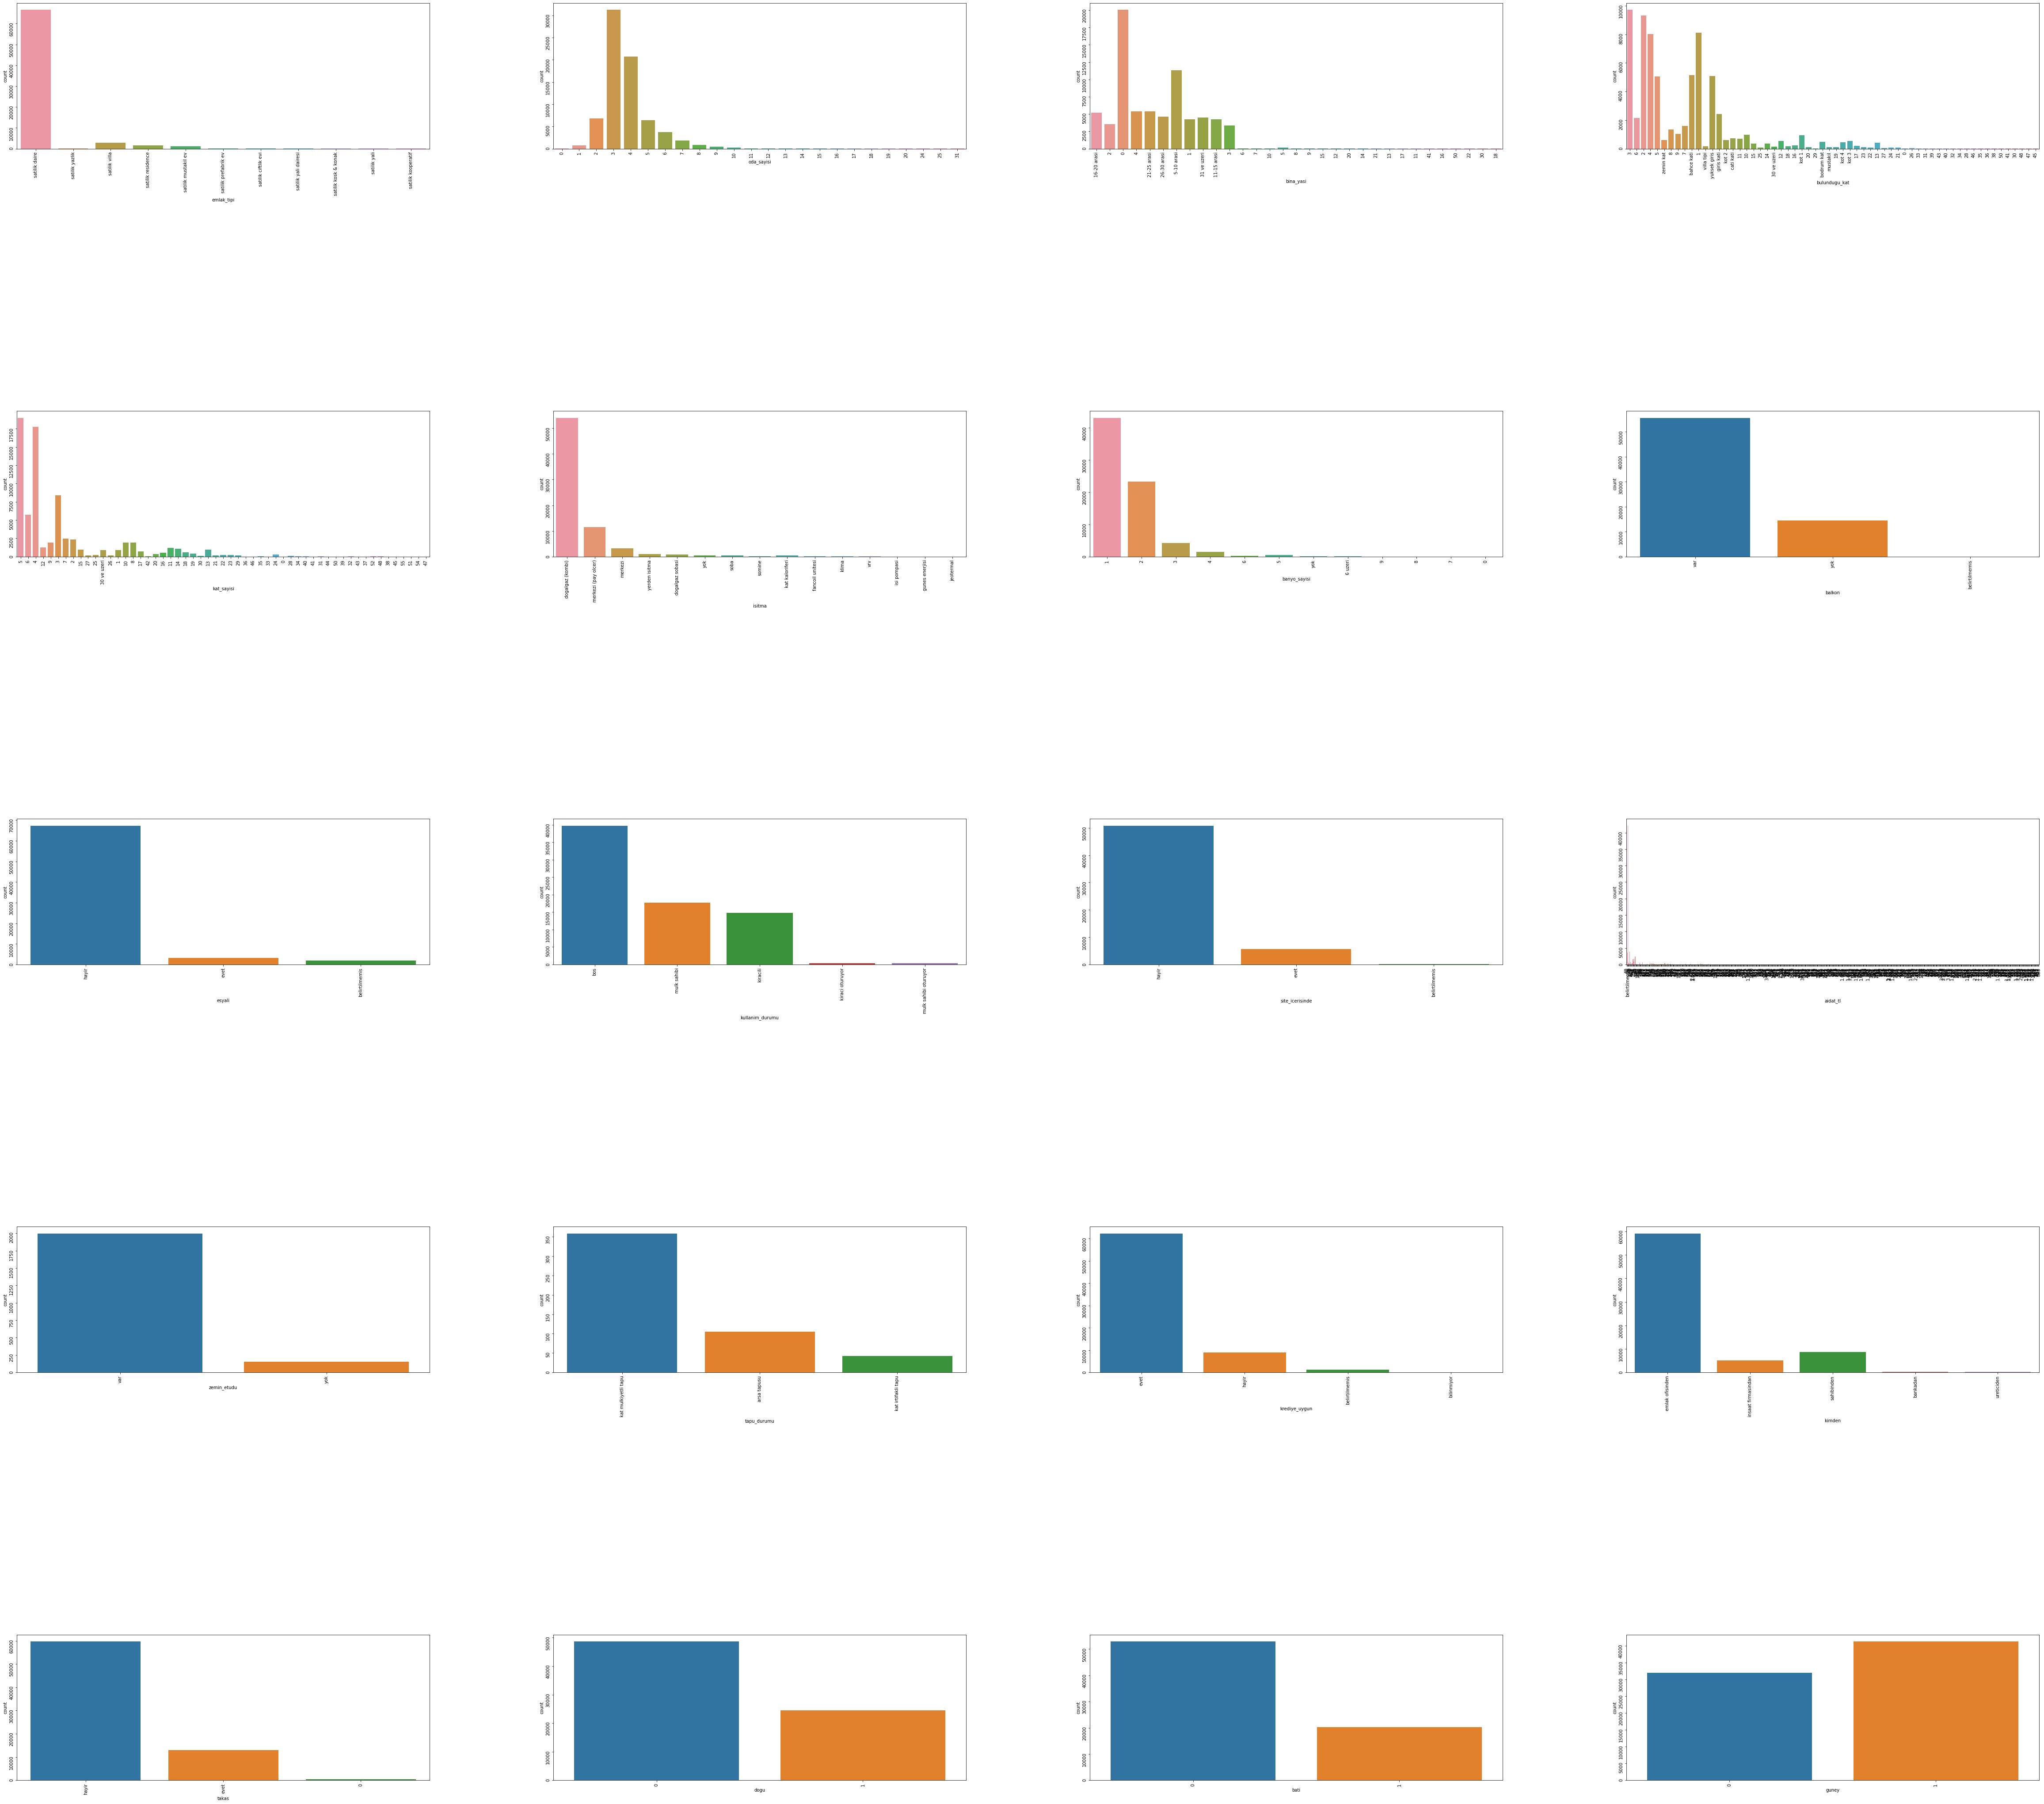

In [4]:
visualizeAllFeatures(df)

1. oda_sayisi feature is a categorical feature but contains integer values. So we handle it as it is **continious feature**
2. If you suppose that the dataset represents whole housing stock in Istanbul, it shows that 60% of total houses in Istanbul builded after 1999

# Combine district and neighbourhood. Remove unique columns

In [21]:
# Combine ilce(district) and mah(neighbourhood) columns if different districts has neighbours with the same name
df['ilce_mah'] = df['ilce']+'-'+df['mah']

In [22]:
# Drop high cardinality columns and already combined ilce and mah columns and create a subset
# aidat_tl column removed because of high cardinality, mixture of str and int variables and less feature importance
trainable_columns = ['coord_lat','coord_long','emlak_tipi','m2_net','m2_brut','oda_sayisi','bina_yasi','bulundugu_kat','kat_sayisi','isitma','banyo_sayisi','balkon','esyali','kullanim_durumu','site_icerisinde','zemin_etudu','tapu_durumu','krediye_uygun','kimden','takas','dogu','bati','kuzey','guney','adsl','ahsap_dograma','akilli_ev','alarm_hirsiz','alarm_yangin','alaturka_tuvalet','aluminyum_dograma','amerikan_kapi','amerikan_mutfak','ankastre_firin','asansor_ic','balkon_ic','barbeku','beyaz_esya','boyali','bulasik_makinesi','buzdolabi','duvar_kagidi','dusakabin','ebeveyn_banyosu','fiber_internet','firin','giyinme_odasi','gomme_dolap','goruntulu_diafon','hilton_banyo','intercom_sistemi','isicam','jakuzi','kartonpiyer','kiler','klima','kuvet','laminat_zemin','marley','mobilya','mutfak_ankastre','mutfak_laminat','mutfak_dogalgazi','pvc_dograma','panjur','parke_zemin','seramik_zemin','set_ustu_ocak','spot_aydinlatma','teras','termosifon','vestiyer','wifi','yuz_tanima__parmak_izi','camasir_kurutma_makinesi','camasir_makinesi','camasir_odasi','celik_kapi','sofben','somine','asansor_dis','buhar_odasi','guvenlik','hamam','hidrofor','isi_yalitim','jenerator','kablo_tv','kapali_garaj','kapici','kres','mustakil_havuzlu','otopark','oyun_parki','sauna','ses_yalitimi','siding','spor_alani','su_deposu','tenis_kortu','uydu','yangin_merdiveni','yuzme_havuzu_acik','yuzme_havuzu_kapali','arac_park_yeri','asansor_engelli','banyo_engelli','genis_koridor','giris_rampa','merdiven','mutfak','oda_kapisi','park_engelli','priz_elektrik_anahtari','tutamak_korkuluk','tuvalet','yuzme_havuzu','alisveris_merkezi','belediye','cami','cemevi','denize_sifir','eczane','eglence_merkezi','fuar','hastane','havra','kilise','lise','market','park_muhit','polis_merkezi','saglik_ocagi','semt_pazari','spor_salonu','universite','ilkokulortaokul','itfaiye','sehir_merkezi','anayol','avrasya_tuneli','bogaz_kopruleri','cadde','deniz_otobusu','dolmus','e5','havaalani','marmaray','metro','metrobus','minibus','otobus_duragi','sahil','tem','teleferik','tramvay','tren_istasyonu','troleybus','iskele','bogaz','deniz','doga','gol','havuz','sehir','ara_kat','ara_kat_dubleks','bahce_dubleksi','bahce_kati','bahceli','en_ust_kat','garaj_dukkan_ustu','giris_kati','kat_dubleksi','mustakil_girisli','ters_dubleks','tripleks','zemin_kat','cati_dubleksi','ilce_mah','price']
df = df[trainable_columns]

In [23]:
df

,coord_lat,coord_long,emlak_tipi,m2_net,m2_brut,oda_sayisi,bina_yasi,bulundugu_kat,kat_sayisi,isitma,banyo_sayisi,balkon,esyali,kullanim_durumu,site_icerisinde,zemin_etudu,tapu_durumu,krediye_uygun,kimden,takas,dogu,bati,kuzey,guney,adsl,ahsap_dograma,akilli_ev,alarm_hirsiz,alarm_yangin,alaturka_tuvalet,aluminyum_dograma,amerikan_kapi,amerikan_mutfak,ankastre_firin,asansor_ic,balkon_ic,barbeku,beyaz_esya,boyali,bulasik_makinesi,buzdolabi,duvar_kagidi,dusakabin,ebeveyn_banyosu,fiber_internet,firin,giyinme_odasi,gomme_dolap,goruntulu_diafon,hilton_banyo,intercom_sistemi,isicam,jakuzi,kartonpiyer,kiler,klima,kuvet,laminat_zemin,marley,mobilya,mutfak_ankastre,mutfak_laminat,mutfak_dogalgazi,pvc_dograma,panjur,parke_zemin,seramik_zemin,set_ustu_ocak,spot_aydinlatma,teras,termosifon,vestiyer,wifi,yuz_tanima__parmak_izi,camasir_kurutma_makinesi,camasir_makinesi,camasir_odasi,celik_kapi,sofben,somine,asansor_dis,buhar_odasi,guvenlik,hamam,hidrofor,isi_yalitim,jenerator,kablo_tv,kapali_garaj,kapici,kres,mustakil_havuzlu,otopark,oyun_parki,sauna,ses_yalitimi,siding,spor_alani,su_deposu,tenis_kortu,uydu,yangin_merdiveni,yuzme_havuzu_acik,yuzme_havuzu_kapali,arac_park_yeri,asansor_engelli,banyo_engelli,genis_koridor,giris_rampa,merdiven,mutfak,oda_kapisi,park_engelli,priz_elektrik_anahtari,tutamak_korkuluk,tuvalet,yuzme_havuzu,alisveris_merkezi,belediye,cami,cemevi,denize_sifir,eczane,eglence_merkezi,fuar,hastane,havra,kilise,lise,market,park_muhit,polis_merkezi,saglik_ocagi,semt_pazari,spor_salonu,universite,ilkokulortaokul,itfaiye,sehir_merkezi,anayol,avrasya_tuneli,bogaz_kopruleri,cadde,deniz_otobusu,dolmus,e5,havaalani,marmaray,metro,metrobus,minibus,otobus_duragi,sahil,tem,teleferik,tramvay,tren_istasyonu,troleybus,iskele,bogaz,deniz,doga,gol,havuz,sehir,ara_kat,ara_kat_dubleks,bahce_dubleksi,bahce_kati,bahceli,en_ust_kat,garaj_dukkan_ustu,giris_kati,kat_dubleksi,mustakil_girisli,ters_dubleks,tripleks,zemin_kat,cati_dubleksi,ilce_mah,price
0,41.058402,28.992622,satilik daire,120.0,130.0,4,16-20 arasi,3,5,dogalgaz (kombi),1,var,hayir,bos,hayir,NaN,NaN,evet,emlak ofisinden,hayir,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,sisli-19 mayis mh.,530000
1,41.058140,28.992479,satilik daire,130.0,140.0,4,2,6,6,dogalgaz (kombi),1,var,hayir,mulk sahibi,hayir,NaN,NaN,hayir,emlak ofisinden,hayir,1,0,0,1,1,0,0,0,0,0,0,1,0,1,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,1,1,1,1,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,1,1,1,0,0,1,1,1,0,0,1,1,0,1,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,0,1,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,sisli-19 mayis mh.,750000
2,41.059928,28.989360,satilik daire,75.0,85.0,3,0,2,4,dogalgaz (kombi),1,var,hayir,bos,hayir,NaN,NaN,evet,emlak ofisinden,hayir,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,sisli-19 mayis mh.,900000
3,41.060501,28.993628,satilik daire,90.0,100.0,3,16-20 arasi,4,5,dogalgaz (kombi),1,var,hayir,kiracili,hayir,NaN,NaN,evet,emlak ofisinden,hayir,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,1,1,0,1,1,1,0,1,0,0,0,0,1,1,0,0,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,sisli-19 mayis mh.,550000
4,41.073230,28.987365,satilik daire,45.0,55.0,2,0,5,6,dogalgaz (kombi),1,yok,hayir,bos,hayir,NaN,NaN,evet,

In [24]:
#try:
#    df.drop(drop_columns, axis=1, inplace=True)
#    df.to_csv('../data/emlakfinal2.csv')
#except Exception as e:
#    print (e)

# Handling Missing Values

In [25]:
# fill missing values
most_frequent_values = dict(df.mode().iloc[0])
most_frequent_values['zemin_etudu'] = 'yok' # "Not having" zemin etudu is a frequently seen stiuation [Domain knowledge]
df = df.fillna(most_frequent_values)

In [26]:
df

,coord_lat,coord_long,emlak_tipi,m2_net,m2_brut,oda_sayisi,bina_yasi,bulundugu_kat,kat_sayisi,isitma,banyo_sayisi,balkon,esyali,kullanim_durumu,site_icerisinde,zemin_etudu,tapu_durumu,krediye_uygun,kimden,takas,dogu,bati,kuzey,guney,adsl,ahsap_dograma,akilli_ev,alarm_hirsiz,alarm_yangin,alaturka_tuvalet,aluminyum_dograma,amerikan_kapi,amerikan_mutfak,ankastre_firin,asansor_ic,balkon_ic,barbeku,beyaz_esya,boyali,bulasik_makinesi,buzdolabi,duvar_kagidi,dusakabin,ebeveyn_banyosu,fiber_internet,firin,giyinme_odasi,gomme_dolap,goruntulu_diafon,hilton_banyo,intercom_sistemi,isicam,jakuzi,kartonpiyer,kiler,klima,kuvet,laminat_zemin,marley,mobilya,mutfak_ankastre,mutfak_laminat,mutfak_dogalgazi,pvc_dograma,panjur,parke_zemin,seramik_zemin,set_ustu_ocak,spot_aydinlatma,teras,termosifon,vestiyer,wifi,yuz_tanima__parmak_izi,camasir_kurutma_makinesi,camasir_makinesi,camasir_odasi,celik_kapi,sofben,somine,asansor_dis,buhar_odasi,guvenlik,hamam,hidrofor,isi_yalitim,jenerator,kablo_tv,kapali_garaj,kapici,kres,mustakil_havuzlu,otopark,oyun_parki,sauna,ses_yalitimi,siding,spor_alani,su_deposu,tenis_kortu,uydu,yangin_merdiveni,yuzme_havuzu_acik,yuzme_havuzu_kapali,arac_park_yeri,asansor_engelli,banyo_engelli,genis_koridor,giris_rampa,merdiven,mutfak,oda_kapisi,park_engelli,priz_elektrik_anahtari,tutamak_korkuluk,tuvalet,yuzme_havuzu,alisveris_merkezi,belediye,cami,cemevi,denize_sifir,eczane,eglence_merkezi,fuar,hastane,havra,kilise,lise,market,park_muhit,polis_merkezi,saglik_ocagi,semt_pazari,spor_salonu,universite,ilkokulortaokul,itfaiye,sehir_merkezi,anayol,avrasya_tuneli,bogaz_kopruleri,cadde,deniz_otobusu,dolmus,e5,havaalani,marmaray,metro,metrobus,minibus,otobus_duragi,sahil,tem,teleferik,tramvay,tren_istasyonu,troleybus,iskele,bogaz,deniz,doga,gol,havuz,sehir,ara_kat,ara_kat_dubleks,bahce_dubleksi,bahce_kati,bahceli,en_ust_kat,garaj_dukkan_ustu,giris_kati,kat_dubleksi,mustakil_girisli,ters_dubleks,tripleks,zemin_kat,cati_dubleksi,ilce_mah,price
0,41.058402,28.992622,satilik daire,120.0,130.0,4,16-20 arasi,3,5,dogalgaz (kombi),1,var,hayir,bos,hayir,yok,kat mulkiyetli tapu,evet,emlak ofisinden,hayir,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,sisli-19 mayis mh.,530000
1,41.058140,28.992479,satilik daire,130.0,140.0,4,2,6,6,dogalgaz (kombi),1,var,hayir,mulk sahibi,hayir,yok,kat mulkiyetli tapu,hayir,emlak ofisinden,hayir,1,0,0,1,1,0,0,0,0,0,0,1,0,1,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,1,1,1,1,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,1,1,1,0,0,1,1,1,0,0,1,1,0,1,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,0,1,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,sisli-19 mayis mh.,750000
2,41.059928,28.989360,satilik daire,75.0,85.0,3,0,2,4,dogalgaz (kombi),1,var,hayir,bos,hayir,yok,kat mulkiyetli tapu,evet,emlak ofisinden,hayir,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,sisli-19 mayis mh.,900000
3,41.060501,28.993628,satilik daire,90.0,100.0,3,16-20 arasi,4,5,dogalgaz (kombi),1,var,hayir,kiracili,hayir,yok,kat mulkiyetli tapu,evet,emlak ofisinden,hayir,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,1,1,0,1,1,1,0,1,0,0,0,0,1,1,0,0,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,sisli-19 mayis mh.,550000
4,41.073230,28.987365,satilik daire,45.0,5

# Scaling The Continious Values

In [27]:
df[['coord_lat','coord_long']]

,coord_lat,coord_long
0,41.058402,28.992622
1,41.058140,28.992479
2,41.059928,28.989360
3,41.060501,28.993628
4,41.073230,28.987365
...,...,...
73183,41.064139,28.899969
73184,41.067882,28.894424
73185,41.064030,28.900039
73186,41.070432,28.882307


In [28]:
all_features = list(df.columns)
continious_features = ['coord_lat','coord_long', 'm2_net', 'm2_brut', 'oda_sayisi']
continious_features_plus_target = continious_features + ['price']

for c in continious_features_plus_target:
    all_features.remove(c)
categorical_features = all_features
len(categorical_features)

175

In [13]:
standardizer = StandardScaler()

In [11]:
df_s = standardizer.fit_transform(df[continious_features])
df_s = pd.DataFrame(df_s, columns=continious_features)
df_s.max(axis=0)

NameError: name 'standardizer' is not defined

In [104]:
# Assign the scaled features
df[['coord_lat','coord_long', 'm2_net', 'm2_brut', 'oda_sayisi']] = df_s

NameError: name 'df_s' is not defined

In [29]:
pd.set_option('display.max_columns', None)
df

,coord_lat,coord_long,emlak_tipi,m2_net,m2_brut,oda_sayisi,bina_yasi,bulundugu_kat,kat_sayisi,isitma,banyo_sayisi,balkon,esyali,kullanim_durumu,site_icerisinde,zemin_etudu,tapu_durumu,krediye_uygun,kimden,takas,dogu,bati,kuzey,guney,adsl,ahsap_dograma,akilli_ev,alarm_hirsiz,alarm_yangin,alaturka_tuvalet,aluminyum_dograma,amerikan_kapi,amerikan_mutfak,ankastre_firin,asansor_ic,balkon_ic,barbeku,beyaz_esya,boyali,bulasik_makinesi,buzdolabi,duvar_kagidi,dusakabin,ebeveyn_banyosu,fiber_internet,firin,giyinme_odasi,gomme_dolap,goruntulu_diafon,hilton_banyo,intercom_sistemi,isicam,jakuzi,kartonpiyer,kiler,klima,kuvet,laminat_zemin,marley,mobilya,mutfak_ankastre,mutfak_laminat,mutfak_dogalgazi,pvc_dograma,panjur,parke_zemin,seramik_zemin,set_ustu_ocak,spot_aydinlatma,teras,termosifon,vestiyer,wifi,yuz_tanima__parmak_izi,camasir_kurutma_makinesi,camasir_makinesi,camasir_odasi,celik_kapi,sofben,somine,asansor_dis,buhar_odasi,guvenlik,hamam,hidrofor,isi_yalitim,jenerator,kablo_tv,kapali_garaj,kapici,kres,mustakil_havuzlu,otopark,oyun_parki,sauna,ses_yalitimi,siding,spor_alani,su_deposu,tenis_kortu,uydu,yangin_merdiveni,yuzme_havuzu_acik,yuzme_havuzu_kapali,arac_park_yeri,asansor_engelli,banyo_engelli,genis_koridor,giris_rampa,merdiven,mutfak,oda_kapisi,park_engelli,priz_elektrik_anahtari,tutamak_korkuluk,tuvalet,yuzme_havuzu,alisveris_merkezi,belediye,cami,cemevi,denize_sifir,eczane,eglence_merkezi,fuar,hastane,havra,kilise,lise,market,park_muhit,polis_merkezi,saglik_ocagi,semt_pazari,spor_salonu,universite,ilkokulortaokul,itfaiye,sehir_merkezi,anayol,avrasya_tuneli,bogaz_kopruleri,cadde,deniz_otobusu,dolmus,e5,havaalani,marmaray,metro,metrobus,minibus,otobus_duragi,sahil,tem,teleferik,tramvay,tren_istasyonu,troleybus,iskele,bogaz,deniz,doga,gol,havuz,sehir,ara_kat,ara_kat_dubleks,bahce_dubleksi,bahce_kati,bahceli,en_ust_kat,garaj_dukkan_ustu,giris_kati,kat_dubleksi,mustakil_girisli,ters_dubleks,tripleks,zemin_kat,cati_dubleksi,ilce_mah,price
0,41.058402,28.992622,satilik daire,120.0,130.0,4,16-20 arasi,3,5,dogalgaz (kombi),1,var,hayir,bos,hayir,yok,kat mulkiyetli tapu,evet,emlak ofisinden,hayir,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,sisli-19 mayis mh.,530000
1,41.058140,28.992479,satilik daire,130.0,140.0,4,2,6,6,dogalgaz (kombi),1,var,hayir,mulk sahibi,hayir,yok,kat mulkiyetli tapu,hayir,emlak ofisinden,hayir,1,0,0,1,1,0,0,0,0,0,0,1,0,1,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,1,1,1,1,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,1,1,1,0,0,1,1,1,0,0,1,1,0,1,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,0,1,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,sisli-19 mayis mh.,750000
2,41.059928,28.989360,satilik daire,75.0,85.0,3,0,2,4,dogalgaz (kombi),1,var,hayir,bos,hayir,yok,kat mulkiyetli tapu,evet,emlak ofisinden,hayir,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,sisli-19 mayis mh.,900000
3,41.060501,28.993628,satilik daire,90.0,100.0,3,16-20 arasi,4,5,dogalgaz (kombi),1,var,hayir,kiracili,hayir,yok,kat mulkiyetli tapu,evet,emlak ofisinden,hayir,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,1,1,0,1,1,1,0,1,0,0,0,0,1,1,0,0,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,sisli-19 mayis mh.,550000
4,41.073230,28.987365,satilik daire,45.0,5

# Encoding categorical features

In [30]:
len(categorical_features)

175

In [31]:
df['emlak_tipi']

0        satilik daire
1        satilik daire
2        satilik daire
3        satilik daire
4        satilik daire
             ...      
73183    satilik daire
73184    satilik daire
73185    satilik daire
73186    satilik daire
73187    satilik daire
Name: emlak_tipi, Length: 73188, dtype: object

In [32]:
categorical_c = LabelEncoder()
em = categorical_c.fit(df['emlak_tipi'])

In [33]:
em.classes_

array(['satilik ciftlik evi', 'satilik daire', 'satilik kooperatif',
       'satilik kosk & konak', 'satilik mustakil ev',
       'satilik prefabrik ev', 'satilik residence', 'satilik villa',
       'satilik yali', 'satilik yali dairesi', 'satilik yazlik'],
      dtype=object)

In [58]:
# convert categoricals
encoders = {}
df_encoded = {}
for column in categorical_features:
    categorical_convert = LabelEncoder()
    df[column] = categorical_convert.fit_transform(df[column])
    encoders[column] = categorical_convert
    
#df_encoded = pd.DataFrame.from_dict(df_encoded)
#df_encoded['price'] = df['price']
df

,coord_lat,coord_long,emlak_tipi,m2_net,m2_brut,oda_sayisi,bina_yasi,bulundugu_kat,kat_sayisi,isitma,banyo_sayisi,balkon,esyali,kullanim_durumu,site_icerisinde,zemin_etudu,tapu_durumu,krediye_uygun,kimden,takas,dogu,bati,kuzey,guney,adsl,ahsap_dograma,akilli_ev,alarm_hirsiz,alarm_yangin,alaturka_tuvalet,aluminyum_dograma,amerikan_kapi,amerikan_mutfak,ankastre_firin,asansor_ic,balkon_ic,barbeku,beyaz_esya,boyali,bulasik_makinesi,buzdolabi,duvar_kagidi,dusakabin,ebeveyn_banyosu,fiber_internet,firin,giyinme_odasi,gomme_dolap,goruntulu_diafon,hilton_banyo,intercom_sistemi,isicam,jakuzi,kartonpiyer,kiler,klima,kuvet,laminat_zemin,marley,mobilya,mutfak_ankastre,mutfak_laminat,mutfak_dogalgazi,pvc_dograma,panjur,parke_zemin,seramik_zemin,set_ustu_ocak,spot_aydinlatma,teras,termosifon,vestiyer,wifi,yuz_tanima__parmak_izi,camasir_kurutma_makinesi,camasir_makinesi,camasir_odasi,celik_kapi,sofben,somine,asansor_dis,buhar_odasi,guvenlik,hamam,hidrofor,isi_yalitim,jenerator,kablo_tv,kapali_garaj,kapici,kres,mustakil_havuzlu,otopark,oyun_parki,sauna,ses_yalitimi,siding,spor_alani,su_deposu,tenis_kortu,uydu,yangin_merdiveni,yuzme_havuzu_acik,yuzme_havuzu_kapali,arac_park_yeri,asansor_engelli,banyo_engelli,genis_koridor,giris_rampa,merdiven,mutfak,oda_kapisi,park_engelli,priz_elektrik_anahtari,tutamak_korkuluk,tuvalet,yuzme_havuzu,alisveris_merkezi,belediye,cami,cemevi,denize_sifir,eczane,eglence_merkezi,fuar,hastane,havra,kilise,lise,market,park_muhit,polis_merkezi,saglik_ocagi,semt_pazari,spor_salonu,universite,ilkokulortaokul,itfaiye,sehir_merkezi,anayol,avrasya_tuneli,bogaz_kopruleri,cadde,deniz_otobusu,dolmus,e5,havaalani,marmaray,metro,metrobus,minibus,otobus_duragi,sahil,tem,teleferik,tramvay,tren_istasyonu,troleybus,iskele,bogaz,deniz,doga,gol,havuz,sehir,ara_kat,ara_kat_dubleks,bahce_dubleksi,bahce_kati,bahceli,en_ust_kat,garaj_dukkan_ustu,giris_kati,kat_dubleksi,mustakil_girisli,ters_dubleks,tripleks,zemin_kat,cati_dubleksi,ilce_mah,price
0,41.058402,28.992622,1,120.0,130.0,4,10,23,45,0,1,1,2,0,2,1,2,2,1,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,750,530000
1,41.058140,28.992479,1,130.0,140.0,4,13,44,51,0,1,1,2,3,2,1,2,3,1,2,1,0,0,1,1,0,0,0,0,0,0,1,0,1,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,1,1,1,1,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,1,1,1,0,0,1,1,1,0,0,1,1,0,1,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,0,1,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,750,750000
2,41.059928,28.989360,1,75.0,85.0,3,0,12,35,0,1,1,2,0,2,1,2,2,1,2,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,750,900000
3,41.060501,28.993628,1,90.0,100.0,3,10,34,45,0,1,1,2,2,2,1,2,2,1,2,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,1,1,0,1,1,1,0,1,0,0,0,0,1,1,0,0,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,750,550000
4,41.073230,28.987365,1,45.0,55.0,2,0,42,51,0,1,2,2,0,2,1,2,2,1,2,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,1,1,0,0,1,1,0,0,1,0,1,1,0,0,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,514,270000
...,...,...,...,...,...,...,...,...,...,...,...,..

In [61]:
encoders['emlak_tipi'].classes_

array(['satilik ciftlik evi', 'satilik daire', 'satilik kooperatif',
       'satilik kosk & konak', 'satilik mustakil ev',
       'satilik prefabrik ev', 'satilik residence', 'satilik villa',
       'satilik yali', 'satilik yali dairesi', 'satilik yazlik'],
      dtype=object)

# Train Test Split

In [62]:
x_cols = [c for c in df.columns if c != 'price']
# set input matrix and target column
X = df[x_cols]
y = df['price']

In [63]:
# data split train / test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=123)

In [64]:
X_train

,coord_lat,coord_long,emlak_tipi,m2_net,m2_brut,oda_sayisi,bina_yasi,bulundugu_kat,kat_sayisi,isitma,banyo_sayisi,balkon,esyali,kullanim_durumu,site_icerisinde,zemin_etudu,tapu_durumu,krediye_uygun,kimden,takas,dogu,bati,kuzey,guney,adsl,ahsap_dograma,akilli_ev,alarm_hirsiz,alarm_yangin,alaturka_tuvalet,aluminyum_dograma,amerikan_kapi,amerikan_mutfak,ankastre_firin,asansor_ic,balkon_ic,barbeku,beyaz_esya,boyali,bulasik_makinesi,buzdolabi,duvar_kagidi,dusakabin,ebeveyn_banyosu,fiber_internet,firin,giyinme_odasi,gomme_dolap,goruntulu_diafon,hilton_banyo,intercom_sistemi,isicam,jakuzi,kartonpiyer,kiler,klima,kuvet,laminat_zemin,marley,mobilya,mutfak_ankastre,mutfak_laminat,mutfak_dogalgazi,pvc_dograma,panjur,parke_zemin,seramik_zemin,set_ustu_ocak,spot_aydinlatma,teras,termosifon,vestiyer,wifi,yuz_tanima__parmak_izi,camasir_kurutma_makinesi,camasir_makinesi,camasir_odasi,celik_kapi,sofben,somine,asansor_dis,buhar_odasi,guvenlik,hamam,hidrofor,isi_yalitim,jenerator,kablo_tv,kapali_garaj,kapici,kres,mustakil_havuzlu,otopark,oyun_parki,sauna,ses_yalitimi,siding,spor_alani,su_deposu,tenis_kortu,uydu,yangin_merdiveni,yuzme_havuzu_acik,yuzme_havuzu_kapali,arac_park_yeri,asansor_engelli,banyo_engelli,genis_koridor,giris_rampa,merdiven,mutfak,oda_kapisi,park_engelli,priz_elektrik_anahtari,tutamak_korkuluk,tuvalet,yuzme_havuzu,alisveris_merkezi,belediye,cami,cemevi,denize_sifir,eczane,eglence_merkezi,fuar,hastane,havra,kilise,lise,market,park_muhit,polis_merkezi,saglik_ocagi,semt_pazari,spor_salonu,universite,ilkokulortaokul,itfaiye,sehir_merkezi,anayol,avrasya_tuneli,bogaz_kopruleri,cadde,deniz_otobusu,dolmus,e5,havaalani,marmaray,metro,metrobus,minibus,otobus_duragi,sahil,tem,teleferik,tramvay,tren_istasyonu,troleybus,iskele,bogaz,deniz,doga,gol,havuz,sehir,ara_kat,ara_kat_dubleks,bahce_dubleksi,bahce_kati,bahceli,en_ust_kat,garaj_dukkan_ustu,giris_kati,kat_dubleksi,mustakil_girisli,ters_dubleks,tripleks,zemin_kat,cati_dubleksi,ilce_mah
19539,41.183311,28.897102,1,90.0,105.0,3,0,48,35,9,1,1,2,0,1,1,2,2,1,2,0,1,0,1,0,0,0,0,0,0,0,1,1,1,0,1,0,0,1,1,0,1,1,0,1,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,0,1,0,0,1,1,1,1,1,1,1,0,1,1,0,0,1,1,1,0,1,1,1,0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,1,0,1,1,0,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1,0,0,1,1,0,1,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,400
40202,40.983661,29.046025,1,105.0,120.0,4,0,5,5,0,2,2,2,0,2,1,2,2,1,2,1,1,0,1,1,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,1,0,0,0,1,1,0,1,0,1,0,1,0,1,0,0,1,1,1,0,1,1,1,1,1,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,1,1,1,1,1,1,0,0,1,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,1,1,0,1,1,0,0,1,0,1,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,495
31348,41.090455,28.897222,1,75.0,114.0,3,0,47,9,9,1,2,2,0,2,1,2,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,464
13862,41.005647,28.661715,1,100.0,120.0,3,0,34,45,0,2,1,2,0,2,1,2,2,2,1,1,0,0,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,0,0,1,1,1,1,1,1,1,0,0,1,1,1,1,0,1,201
37278,40.977534,28.713917,1,78.0,95.0,3,16,23,35,0,1,1,2,0,2,1,2,2,3,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,1,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0,1,1,1,1,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

# Model

In [65]:
# train the Random Forest algorithm
rf = RandomForestRegressor(n_estimators = 100, n_jobs=-1)
rf = rf.fit(X_train, y_train)

In [66]:
# train the Extra Trees algorithm
et = ExtraTreesRegressor(n_estimators = 100, n_jobs = -1)
et = et.fit(X_train, y_train)

# Predict

In [67]:
y_predict = rf.predict(X_test)
list(y_predict[:20])

[2043300.0,
 470759.98,
 625709.99,
 2319920.0,
 265380.0,
 272627.5,
 425429.9,
 243603.3333333333,
 481280.0,
 2206500.0,
 349150.0,
 302260.0,
 806739.99,
 483185.0,
 341155.0,
 10245000.0,
 595506.56,
 162309.88,
 288125.0,
 1431700.0]

In [70]:
y_predict = et.predict(X_test)
list(y_predict[:20])

[2134180.0,
 475294.99,
 645375.59,
 2616740.0,
 248660.0,
 322439.99,
 759560.0,
 242680.0,
 504315.0,
 1161920.0,
 361540.0,
 335180.0,
 650544.99,
 493005.0,
 318230.0,
 10887450.0,
 507196.79,
 508794.93,
 291885.0,
 454660.0]

In [71]:
y_test[:20]

61118    1100000
56917     395000
43017     480000
37425    2950000
65615     235000
1496      245000
17112     438000
418       200000
56634     475000
32953    1950000
23492     308000
48773     145000
44470     600000
48593     525000
59437     410000
5832     3200000
65707     480000
22867     220000
51981     235000
25094     455000
Name: price, dtype: int64

# Test the Model

In [72]:
explained_variance_score(list(y_test), list(y_predict))

-1.629646557880735

In [73]:
cross_val_score(rf, X, y, cv=5)

array([ 0.45936307, -1.52196069,  0.1809022 ,  0.470277  ,  0.00284605])

In [74]:
cross_val_score(et, X, y, cv=5)

array([-3.36574611e+00, -3.19117225e+00,  3.07940055e-03, -8.90431835e-01,
        3.96156492e-03])

**Result**
Random forest gets higher score than extra Trees algorithm.

# Save The Binary Files

In [75]:
# save preprocessing objects and RF algorithm
joblib.dump(most_frequent_values, "./bin/most_frequent_values.joblib", compress=True)
joblib.dump(encoders, "./bin/encoders.joblib", compress=True)
joblib.dump(rf, "./bin/random_forest_without_scaling.joblib", compress=True)
joblib.dump(et, "./bin/extra_trees_without_scaling.joblib", compress=True)

['./bin/extra_trees_without_scaling.joblib']

# Feature Importance

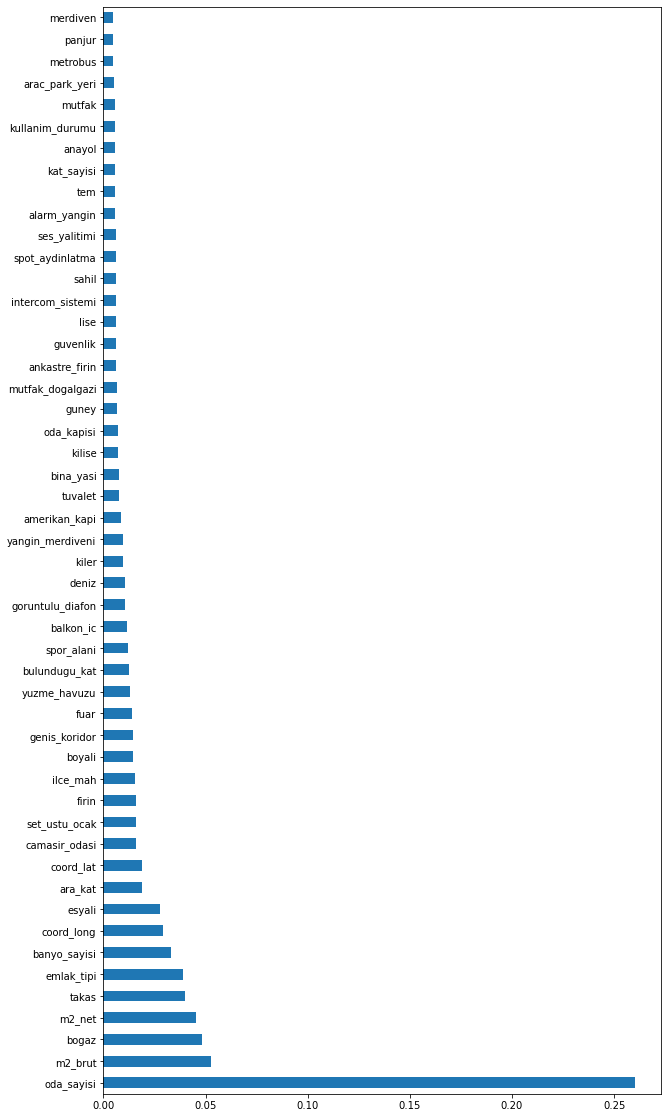

In [77]:
feature_importance = pd.Series(rf.feature_importances_, X_train.columns)
feature_importance.nlargest(50).plot(kind='barh', figsize=(10,20))

### Results of feature importance
1. Size related features is the most important ones.
2. Longitude is more important than latitude. Since Istanbul established in the east-west direction. Most valuable areas are on Bosporus line and as you move away from Bosporus prices goes down. Therefore Bosporus view is the 3th important feature.
3. ilce-mah (district-neighbourhood) is less important than latitude and longitude with it's 10th place.

# Read From Binary Model

In [78]:
most_frequent_values = joblib.load("./bin/most_frequent_values.joblib")
encoders = joblib.load("./bin/encoders.joblib")
rf = joblib.load("./bin/random_forest_without_scaling.joblib")
et = joblib.load("./bin/extra_trees_without_scaling.joblib")

In [80]:
encoders['emlak_tipi'].classes_

array(['satilik ciftlik evi', 'satilik daire', 'satilik kooperatif',
       'satilik kosk & konak', 'satilik mustakil ev',
       'satilik prefabrik ev', 'satilik residence', 'satilik villa',
       'satilik yali', 'satilik yali dairesi', 'satilik yazlik'],
      dtype=object)

# Sample Prediction

In [81]:
input_data = [{
    "ilan_no": 596729488,
    "url": "https://www.sahibinden.com/ilan/emlak-konut-satilik-bir-emlaktan-buyukcekmece-cengiztopel-de-satilik-daire-596729488/detay",
    "ilan_tarihi": "2020-3-15", 
    "origin": "www.sahibinden.com", 
    "il": "istanbul", 
    "ilce": "buyukcekmece", 
    "mah": "alkent 2000 mah.", 
    "coord_lat": 41.0771198432617, 
    "coord_long": 28.6241088314453, 
    "emlak_tipi": "satilik daire", 
    "m2_net": 150, 
    "m2_brut": 160, 
    "oda_sayisi": 5, 
    "bina_yasi": "21-25 arasi", 
    "bulundugu_kat": "3", 
    "kat_sayisi": "3", 
    "isitma": "dogalgaz (kombi)", 
    "banyo_sayisi": "1",
    "balkon": "var", 
    "esyali": "hayir", 
    "kullanim_durumu": "mulk sahibi", 
    "site_icerisinde": "hayir", 
    "aidat_tl": 'belirtilmemis', 
    "zemin_etudu": "yok", 
    "tapu_durumu": "kat mulkiyetli tapu", 
    "krediye_uygun": "evet", 
    "kimden": "emlak ofisinden", 
    "takas": "hayir", 
    "dogu": True,
    "bati": True,
    "kuzey": False,
    "guney": True,
    "adsl": False,
    "ahsap_dograma": False,
    "akilli_ev": False,
    "alarm_hirsiz": True,
    "alarm_yangin": False,
    "alaturka_tuvalet": False,
    "aluminyum_dograma": False,
    "amerikan_kapi": False,
    "amerikan_mutfak": False,
    "ankastre_firin": False,
    "asansor_ic": False,
    "balkon_ic": False,
    "barbeku": False,
    "beyaz_esya": False,
    "boyali": False,
    "bulasik_makinesi": False,
    "buzdolabi": True,
    "duvar_kagidi": True,
    "dusakabin": True,
    "ebeveyn_banyosu": True,
    "fiber_internet": True,
    "firin": True,
    "giyinme_odasi": True,
    "gomme_dolap": True,
    "goruntulu_diafon": True,
    "hilton_banyo": True,
    "intercom_sistemi": True,
    "isicam": True,
    "jakuzi": True,
    "kartonpiyer": True,
    "kiler": True,
    "klima": False,
    "kuvet": False,
    "laminat_zemin": False,
    "marley": False,
    "mobilya": False,
    "mutfak_ankastre": False,
    "mutfak_laminat": False,
    "mutfak_dogalgazi": False,
    "pvc_dograma": False,
    "panjur": False,
    "parke_zemin": False,
    "seramik_zemin": False,
    "set_ustu_ocak": False,
    "spot_aydinlatma": False,
    "teras": False,
    "termosifon": False,
    "vestiyer": False,
    "wifi": False,
    "yuz_tanima__parmak_izi": False,
    "camasir_kurutma_makinesi": False,
    "camasir_makinesi": False,
    "camasir_odasi": False,
    "celik_kapi": False,
    "sofben": False,
    "somine": False,
    "asansor_dis": False,
    "buhar_odasi": False,
    "guvenlik": False,
    "hamam": False,
    "hidrofor": False,
    "isi_yalitim": False,
    "jenerator": False,
    "kablo_tv": False,
    "kapali_garaj": False,
    "kapici": False,
    "kres": False,
    "mustakil_havuzlu": False,
    "otopark": False,
    "oyun_parki": False,
    "sauna": False,
    "ses_yalitimi": False,
    "siding": False,
    "spor_alani": False,
    "su_deposu": False,
    "tenis_kortu": False,
    "uydu": False,
    "yangin_merdiveni": False,
    "yuzme_havuzu_acik": False,
    "yuzme_havuzu_kapali": False,
    "arac_park_yeri": False,
    "asansor_engelli": False,
    "banyo_engelli": False,
    "genis_koridor": False,
    "giris_rampa": False,
    "merdiven": False,
    "mutfak": False,
    "oda_kapisi": False,
    "park_engelli": False,
    "priz_elektrik_anahtari": False,
    "tutamak_korkuluk": False,
    "tuvalet": False,
    "yuzme_havuzu": False,
    "alisveris_merkezi": False,
    "belediye": False,
    "cami": False,
    "cemevi": False,
    "denize_sifir": False,
    "eczane": False,
    "eglence_merkezi": False,
    "fuar": False,
    "hastane": False,
    "havra": False,
    "kilise": False,
    "lise": False,
    "market": False,
    "park_muhit": False,
    "polis_merkezi": False,
    "saglik_ocagi": False,
    "semt_pazari": False,
    "spor_salonu": False,
    "universite": False,
    "ilkokulortaokul": False,
    "itfaiye": False,
    "sehir_merkezi": False,
    "anayol": False,
    "avrasya_tuneli": False,
    "bogaz_kopruleri": False,
    "cadde": False,
    "deniz_otobusu": False,
    "dolmus": False,
    "e5": False,
    "havaalani": True,
    "marmaray": False,
    "metro": False,
    "metrobus": True,
    "minibus": True,
    "otobus_duragi": False,
    "sahil": False,
    "tem": False,
    "teleferik": False,
    "tramvay": False,
    "tren_istasyonu": False,
    "troleybus": False,
    "iskele": True,
    "bogaz": False,
    "deniz": False,
    "doga": False,
    "gol": False,
    "havuz": False,
    "sehir": False,
    "ara_kat": False,
    "ara_kat_dubleks": False,
    "bahce_dubleksi": False,
    "bahce_kati": False,
    "bahceli": False,
    "en_ust_kat": False,
    "garaj_dukkan_ustu": False,
    "giris_kati": False,
    "kat_dubleksi": False,
    "mustakil_girisli": False,
    "ters_dubleks": False,
    "tripleks": False,
    "zemin_kat": False,
    "cati_dubleksi": False,
    "price": 500000, "seller": "Gönül Topcan", "phone": "05359246688", "userid": "afOhpdUzDBhFL1ltMsCS0CQ",
    "modified_at": "2020-05-24T18:57"
},
{
    "ilan_no": 696729488,
    "url": "https://www.sahibinden.com/ilan/emlak-konut-satilik-bir-emlaktan-buyukcekmece-cengiztopel-de-satilik-daire-596729488/detay",
    "ilan_tarihi": "2020-3-15", 
    "origin": "www.sahibinden.com", 
    "il": "istanbul", 
    "ilce": "sisli", 
    "mah": "ferikoy mh.", 
    "coord_lat": 40.9745644690618, 
    "coord_long": 28.7223167934244, 
    "emlak_tipi": "satilik daire", 
    "m2_net": 100, 
    "m2_brut": 100, 
    "oda_sayisi": 3, 
    "bina_yasi": "21-25 arasi", 
    "bulundugu_kat": "bahce kati", 
    "kat_sayisi": "5", 
    "isitma": "dogalgaz (kombi)", 
    "banyo_sayisi": "1",
    "balkon": "var", 
    "esyali": "hayir", 
    "kullanim_durumu": "bos", 
    "site_icerisinde": "hayir", 
    "aidat_tl": "21", 
    "zemin_etudu": "yok", 
    "tapu_durumu": "kat mulkiyetli tapu", 
    "krediye_uygun": "evet", 
    "kimden": "emlak ofisinden", 
    "takas": "hayir", 
    "dogu": False,
    "bati": True,
    "kuzey": False,
    "guney": True,
    "adsl": False,
    "ahsap_dograma": False,
    "akilli_ev": False,
    "alarm_hirsiz": False,
    "alarm_yangin": False,
    "alaturka_tuvalet": False,
    "aluminyum_dograma": False,
    "amerikan_kapi": False,
    "amerikan_mutfak": False,
    "ankastre_firin": False,
    "asansor_ic": False,
    "balkon_ic": False,
    "barbeku": False,
    "beyaz_esya": False,
    "boyali": False,
    "bulasik_makinesi": False,
    "buzdolabi": True,
    "duvar_kagidi": True,
    "dusakabin": True,
    "ebeveyn_banyosu": True,
    "fiber_internet": True,
    "firin": True,
    "giyinme_odasi": True,
    "gomme_dolap": True,
    "goruntulu_diafon": True,
    "hilton_banyo": True,
    "intercom_sistemi": True,
    "isicam": True,
    "jakuzi": True,
    "kartonpiyer": True,
    "kiler": True,
    "klima": False,
    "kuvet": False,
    "laminat_zemin": False,
    "marley": False,
    "mobilya": False,
    "mutfak_ankastre": False,
    "mutfak_laminat": False,
    "mutfak_dogalgazi": False,
    "pvc_dograma": False,
    "panjur": False,
    "parke_zemin": False,
    "seramik_zemin": False,
    "set_ustu_ocak": False,
    "spot_aydinlatma": False,
    "teras": False,
    "termosifon": False,
    "vestiyer": False,
    "wifi": False,
    "yuz_tanima__parmak_izi": False,
    "camasir_kurutma_makinesi": False,
    "camasir_makinesi": False,
    "camasir_odasi": False,
    "celik_kapi": False,
    "sofben": False,
    "somine": False,
    "asansor_dis": False,
    "buhar_odasi": False,
    "guvenlik": False,
    "hamam": False,
    "hidrofor": False,
    "isi_yalitim": False,
    "jenerator": False,
    "kablo_tv": False,
    "kapali_garaj": False,
    "kapici": False,
    "kres": False,
    "mustakil_havuzlu": False,
    "otopark": False,
    "oyun_parki": False,
    "sauna": False,
    "ses_yalitimi": False,
    "siding": False,
    "spor_alani": False,
    "su_deposu": False,
    "tenis_kortu": False,
    "uydu": False,
    "yangin_merdiveni": False,
    "yuzme_havuzu_acik": False,
    "yuzme_havuzu_kapali": False,
    "arac_park_yeri": False,
    "asansor_engelli": False,
    "banyo_engelli": False,
    "genis_koridor": False,
    "giris_rampa": False,
    "merdiven": False,
    "mutfak": False,
    "oda_kapisi": False,
    "park_engelli": False,
    "priz_elektrik_anahtari": False,
    "tutamak_korkuluk": False,
    "tuvalet": False,
    "yuzme_havuzu": False,
    "alisveris_merkezi": False,
    "belediye": False,
    "cami": False,
    "cemevi": False,
    "denize_sifir": False,
    "eczane": False,
    "eglence_merkezi": False,
    "fuar": False,
    "hastane": False,
    "havra": False,
    "kilise": False,
    "lise": False,
    "market": False,
    "park_muhit": False,
    "polis_merkezi": False,
    "saglik_ocagi": False,
    "semt_pazari": False,
    "spor_salonu": False,
    "universite": False,
    "ilkokulortaokul": False,
    "itfaiye": False,
    "sehir_merkezi": False,
    "anayol": False,
    "avrasya_tuneli": False,
    "bogaz_kopruleri": False,
    "cadde": False,
    "deniz_otobusu": False,
    "dolmus": False,
    "e5": False,
    "havaalani": True,
    "marmaray": False,
    "metro": False,
    "metrobus": True,
    "minibus": True,
    "otobus_duragi": False,
    "sahil": False,
    "tem": False,
    "teleferik": False,
    "tramvay": False,
    "tren_istasyonu": False,
    "troleybus": False,
    "iskele": True,
    "bogaz": False,
    "deniz": False,
    "doga": False,
    "gol": False,
    "havuz": False,
    "sehir": False,
    "ara_kat": False,
    "ara_kat_dubleks": False,
    "bahce_dubleksi": False,
    "bahce_kati": False,
    "bahceli": False,
    "en_ust_kat": False,
    "garaj_dukkan_ustu": False,
    "giris_kati": False,
    "kat_dubleksi": False,
    "mustakil_girisli": False,
    "ters_dubleks": False,
    "tripleks": False,
    "zemin_kat": False,
    "cati_dubleksi": False,
    "price": 300000, "seller": "Gönül Topcan", "phone": "05359246688", "userid": "afOhpdUzDBhFL1ltMsCS0CQ",
    "modified_at": "2020-05-24T18:57"
}
]

In [24]:
import json

(json.dumps(input_data[0]))

'{"ilan_no": 596729488, "url": "https://www.sahibinden.com/ilan/emlak-konut-satilik-bir-emlaktan-buyukcekmece-cengiztopel-de-satilik-daire-596729488/detay", "ilan_tarihi": "2020-3-15", "origin": "www.sahibinden.com", "il": "istanbul", "ilce": "buyukcekmece", "mah": "alkent 2000 mah.", "coord_lat": 41.0771198432617, "coord_long": 28.6241088314453, "emlak_tipi": "satilik daire", "m2_net": 150, "m2_brut": 160, "oda_sayisi": 5, "bina_yasi": "21-25 arasi", "bulundugu_kat": "3", "kat_sayisi": 3, "isitma": "dogalgaz (kombi)", "banyo_sayisi": 1, "balkon": "var", "esyali": "hayir", "kullanim_durumu": "mulk sahibi", "site_icerisinde": "hayir", "aidat_tl": "belirtilmemis", "zemin_etudu": "yok", "tapu_durumu": "kat mulkiyetli tapu", "krediye_uygun": "evet", "kimden": "emlak ofisinden", "takas": "hayir", "dogu": true, "bati": true, "kuzey": false, "guney": true, "adsl": false, "ahsap_dograma": false, "akilli_ev": false, "alarm_hirsiz": true, "alarm_yangin": false, "alaturka_tuvalet": false, "alumin

In [82]:
class MyRandomForestRegressor(object):
    
    # Change instance variables to class variables
    
    def __init__(self, input_data):
        # JSON to pandas DataFrame
        path_to_artifacts = "bin/"
        self.values_fill_missing = joblib.load(path_to_artifacts + "most_frequent_values.joblib")
        self.encoders = joblib.load(path_to_artifacts + "encoders.joblib")
        self.model = joblib.load(path_to_artifacts + "random_forest_without_scaling.joblib")

        self.input_data = pd.DataFrame(input_data)
        self.target_column = 'price'
        self.target = self.input_data[self.target_column]
        self.ilan_no = self.input_data['ilan_no'] 
        self.all_columns = ['coord_lat','coord_long','emlak_tipi','m2_net','m2_brut','oda_sayisi','bina_yasi','bulundugu_kat','kat_sayisi','isitma','banyo_sayisi','balkon','esyali','kullanim_durumu','site_icerisinde','zemin_etudu','tapu_durumu','krediye_uygun','kimden','takas','dogu','bati','kuzey','guney','adsl','ahsap_dograma','akilli_ev','alarm_hirsiz','alarm_yangin','alaturka_tuvalet','aluminyum_dograma','amerikan_kapi','amerikan_mutfak','ankastre_firin','asansor_ic','balkon_ic','barbeku','beyaz_esya','boyali','bulasik_makinesi','buzdolabi','duvar_kagidi','dusakabin','ebeveyn_banyosu','fiber_internet','firin','giyinme_odasi','gomme_dolap','goruntulu_diafon','hilton_banyo','intercom_sistemi','isicam','jakuzi','kartonpiyer','kiler','klima','kuvet','laminat_zemin','marley','mobilya','mutfak_ankastre','mutfak_laminat','mutfak_dogalgazi','pvc_dograma','panjur','parke_zemin','seramik_zemin','set_ustu_ocak','spot_aydinlatma','teras','termosifon','vestiyer','wifi','yuz_tanima__parmak_izi','camasir_kurutma_makinesi','camasir_makinesi','camasir_odasi','celik_kapi','sofben','somine','asansor_dis','buhar_odasi','guvenlik','hamam','hidrofor','isi_yalitim','jenerator','kablo_tv','kapali_garaj','kapici','kres','mustakil_havuzlu','otopark','oyun_parki','sauna','ses_yalitimi','siding','spor_alani','su_deposu','tenis_kortu','uydu','yangin_merdiveni','yuzme_havuzu_acik','yuzme_havuzu_kapali','arac_park_yeri','asansor_engelli','banyo_engelli','genis_koridor','giris_rampa','merdiven','mutfak','oda_kapisi','park_engelli','priz_elektrik_anahtari','tutamak_korkuluk','tuvalet','yuzme_havuzu','alisveris_merkezi','belediye','cami','cemevi','denize_sifir','eczane','eglence_merkezi','fuar','hastane','havra','kilise','lise','market','park_muhit','polis_merkezi','saglik_ocagi','semt_pazari','spor_salonu','universite','ilkokulortaokul','itfaiye','sehir_merkezi','anayol','avrasya_tuneli','bogaz_kopruleri','cadde','deniz_otobusu','dolmus','e5','havaalani','marmaray','metro','metrobus','minibus','otobus_duragi','sahil','tem','teleferik','tramvay','tren_istasyonu','troleybus','iskele','bogaz','deniz','doga','gol','havuz','sehir','ara_kat','ara_kat_dubleks','bahce_dubleksi','bahce_kati','bahceli','en_ust_kat','garaj_dukkan_ustu','giris_kati','kat_dubleksi','mustakil_girisli','ters_dubleks','tripleks','zemin_kat','cati_dubleksi','ilce_mah']
        self.unnecessary_columns = ['ilan_no', 'url', 'ilan_tarihi', 'origin', 'il', 'ilce', 'mah', 'seller', 'phone', 'userid']
        self.continious_features = ['coord_lat', 'coord_long', 'm2_net', 'm2_brut', 'oda_sayisi']

        

    def preprocessing(self):
        # combine district and neighbourhood
        self.input_data['ilce_mah'] = self.input_data['ilce']+'-'+self.input_data['mah']

        # drop unneccassary columns
        self.processed_data = self.input_data[self.all_columns]
        
        # fill missing values
        self.processed_data.fillna(self.values_fill_missing, inplace=True)    
        
        # get categorical features
        self.categorical_features = [
            item for item in self.processed_data if item not in (self.continious_features + [self.target_column])
        ]
        
        # scale continious features [later phase]

        # encode categorical features
        encoded_data = {}
        for column in self.all_columns:
            # scanning in categorical and continious features
            try:
                # If the feature is categorical then encode the categories
                categorical_convert = self.encoders[column]
                encoded_data[column] = categorical_convert.transform(self.processed_data[column])
            except:   
                # If the feature is not categorical the add as it is
                encoded_data[column] = self.input_data[column]
        
        return encoded_data

    def predict(self, input_data):
        input_df = pd.DataFrame.from_dict(input_data)
        return self.model.predict(input_df)

    def postprocessing(self, predictions):
        result = []
        for key, pred in enumerate(predictions):
            label = "ucuz"
            if pred < self.input_data[self.target_column][key]: label = "pahali"
                
            actual_price = self.input_data[self.target_column][key]
            result.append({
                "ilan_no": self.ilan_no[key],
                "actual": actual_price,
                "prediction": pred,
                "diff_nominal": round(actual_price - pred),
                "diff_percentage": round(100 * (actual_price - pred) / actual_price, 2),
                "label": label,
                "status": "OK"
            })
        
        return result

    def compute_prediction(self):
        try:
            encoded_data = self.preprocessing()
            
            prediction = self.predict(encoded_data)
            
            prediction = self.postprocessing(prediction)

        except Exception as e:
            return {"status": "Error", "message": str(e)}

        return prediction

In [83]:
my_alg = MyRandomForestRegressor(input_data)

In [84]:
abc = my_alg.preprocessing()

C:\Users\user\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [85]:
abc['bina_yasi']

array([16, 16])

In [86]:
my_alg.compute_prediction()

[{'ilan_no': 596729488,
  'actual': 500000,
  'prediction': 439094.99,
  'diff_nominal': 60905.0,
  'diff_percentage': 12.18,
  'label': 'pahali',
  'status': 'OK'},
 {'ilan_no': 696729488,
  'actual': 300000,
  'prediction': 265784.99,
  'diff_nominal': 34215.0,
  'diff_percentage': 11.41,
  'label': 'pahali',
  'status': 'OK'}]

### Next
1. Add ilan_tarihi column